In [1]:
# Solves a bounded least-squares problem.
import cvxpy as cp
import numpy as np

# Problem data.
m = 10
n = 5
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = []
prob = cp.Problem(objective, constraints)

print("Optimal objective value", prob.solve())
print("Optimal variable value")
print(x.value) # A numpy ndarray.

Optimal objective value 3.570571785264811
Optimal variable value
[-0.29904821 -0.35394235  0.26967701 -0.00749537 -0.23387534]


In [2]:
print(np.linalg.inv(A.T @ A) @ A.T @ b)

[-0.29904821 -0.35394235  0.26967701 -0.00749537 -0.23387534]


In [3]:
# 5.(a)
data = np.loadtxt("xy_train.csv", delimiter=',')
print(data.shape)
n = data.shape[0]

(200, 3)


In [4]:
beta = cp.Variable(2)
beta_0 = cp.Variable()
kersi = cp.Variable(n)
C = cp.Parameter(nonneg=True)
objective = cp.Minimize(0.5 * cp.sum_squares(beta) + cp.sum(kersi))
constraints = []
for i in range(n):
    constraints.append(data[i, 2] * (data[i, 0:2].T @ beta + beta_0) >= 1 - kersi[i])
    constraints.append(kersi[i] >= 0)
C.value = 1
prob = cp.Problem(objective, constraints)
prob.solve()
print(prob.status)
print("optimal objective value", prob.value)
print("beta, beta_0:", beta.value, beta_0.value)
print("kersi:", kersi.value)


optimal
optimal objective value 36.748932649263416
beta, beta_0: [1.41967191 1.24607477] -2.823727594195055
kersi: [9.43508129e-01 9.99942827e-31 9.99942827e-31 4.07471066e-02
 9.99942827e-31 9.99942827e-31 9.99942827e-31 9.99942827e-31
 9.99942827e-31 3.68137508e+00 9.99942827e-31 9.99942827e-31
 9.99942827e-31 9.99942827e-31 9.99942827e-31 9.99942827e-31
 9.99942827e-31 9.99942827e-31 9.99942827e-31 9.99942827e-31
 9.99942827e-31 9.99942827e-31 9.99942827e-31 9.99942827e-31
 9.99942827e-31 8.60142881e-01 1.58410284e+00 9.99942827e-31
 9.99942827e-31 9.99942827e-31 9.99942827e-31 9.99942827e-31
 9.99942827e-31 9.99942827e-31 6.70299524e-02 9.99942827e-31
 9.99942827e-31 9.99942827e-31 9.99942827e-31 9.99942827e-31
 1.59560374e+00 9.99942827e-31 9.99942827e-31 9.99942827e-31
 9.99942827e-31 9.99942827e-31 9.99942827e-31 9.99942827e-31
 9.99942827e-31 9.99942827e-31 3.86150295e-01 9.99942827e-31
 1.52193191e+00 3.88162375e-21 9.99942827e-31 9.99942827e-31
 9.99942827e-31 9.99942827e-31 

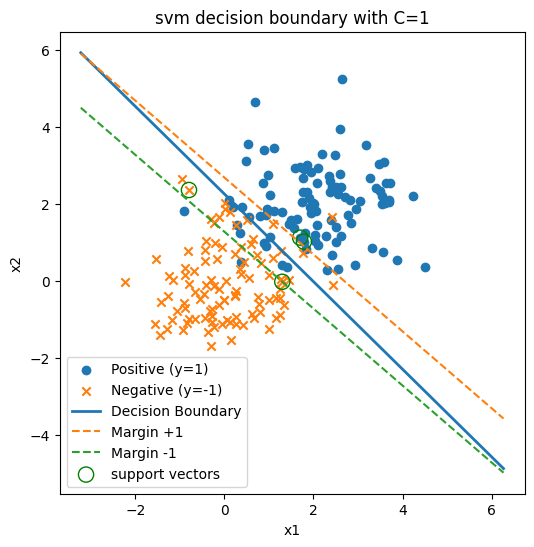

In [5]:
import matplotlib.pyplot as plt
X = data[:, 0:2]
y = data[:, 2]

beta_vec = beta.value
beta0 = beta_0.value

plt.figure(figsize=(6,6))

plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label='Positive (y=1)')
plt.scatter(X[y==-1, 0], X[y==-1, 1], marker='x', label='Negative (y=-1)')

xx = np.linspace(np.min(X[:, 0])-1, np.max(X[:, 1])+1, 200)
yy = -(beta_vec[0] * xx + beta0) / beta_vec[1]
plt.plot(xx, yy, label='Decision Boundary', linewidth=2)

# margins: beta^T x + beta0 = +-1
yy_pos = -(beta_vec[0] * xx + beta0 -1) / beta_vec[0]
yy_neg = -(beta_vec[0] * xx + beta0 + 1) / beta_vec[0]

plt.plot(xx, yy_pos, '--', label='Margin +1')
plt.plot(xx, yy_neg, '--', label='Margin -1')

# highlight support vectors
decision_values = y * (X @ beta_vec + beta0)
sv_mask = np.isclose(decision_values, 1, atol=1e-2)

plt.scatter(X[sv_mask, 0], X[sv_mask, 1], s=120, facecolors='none', edgecolors='g', label='support vectors')

plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("svm decision boundary with C={}".format(C.value))
plt.show()


In [9]:
# Part iii: Solve the dual SVM problem
data = np.loadtxt("xy_train.csv", delimiter=',')
print(data.shape)
n = data.shape[0]

# Extract features and labels
X = data[:, 0:2]
y = data[:, 2]

# Create X_tilde: rows are y_i * x_i
X_tilde = y[:, None] * X

# Pre-compute Gram matrix
G = X_tilde @ X_tilde.T
G_param = cp.psd_wrap(G)

# Define the dual variable
w = cp.Variable(n)
C = cp.Parameter()
C.value = 1

# Constraints: 0 <= w <= C and w^T y = 0
constraints = []
constraints.append(w >= 0)
constraints.append(w <= C)
constraints.append(w @ y == 0)

objective = cp.Maximize(-0.5 * cp.quad_form(w, G_param) + cp.sum(w))

prob = cp.Problem(objective, constraints)
prob.solve(verbose=True)

print(f"Status: {prob.status}")
print(f"Optimal criterion value: {prob.value:.6f}")
print(f"\nX_tilde^T @ w (should match beta from part i):")
beta_dual = X_tilde.T @ w.value
print(f"  beta = [{beta_dual[0]:.6f}, {beta_dual[1]:.6f}]")

(CVXPY) Nov 16 10:05:22 AM: Your problem has 200 variables, 401 constraints, and 1 parameters.
(CVXPY) Nov 16 10:05:22 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 16 10:05:22 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 16 10:05:22 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 16 10:05:22 AM: Compiling problem (target solver=OSQP).
(CVXPY) Nov 16 10:05:22 AM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Nov 16 10:05:22 AM: Applying reduction FlipObjective
(CVXPY) Nov 16 10:05:22 AM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 16 10:05:22 AM: Applying reduction Qp2SymbolicQp
(CVXPY) Nov 16 10:05:22 AM: Applying reduction QpMatrixStuffing
(CVXPY) Nov 16 10:05:22 AM: Applying reduction OSQP
(CVXPY) Nov 16 10:05:22 AM: Finished problem compilation (took 1.560e-02 seconds).
(CVXPY) Nov 16 10:05:22 AM: 

(200, 3)
                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 200, constraints m = 401
          nnz(P) + nnz(A) = 20700
settings: algebra = Built-in,
        

(CVXPY) Nov 16 10:05:23 AM: Problem status: optimal
(CVXPY) Nov 16 10:05:23 AM: Optimal value: 3.675e+01
(CVXPY) Nov 16 10:05:23 AM: Compilation took 1.560e-02 seconds
(CVXPY) Nov 16 10:05:23 AM: Solver (including time spent in interface) took 2.660e-01 seconds


6400  -3.6883e+01   1.05e-03   3.21e-03  -1.37e-01   3.21e-03   2.28e-01    1.80e-01s
6600  -3.6880e+01   1.04e-03   9.42e-04  -1.30e-01   1.04e-03   2.28e-01    1.85e-01s
6800  -3.6769e+01   1.62e-04   2.92e-03  -1.77e-02   2.92e-03   2.28e-01    1.90e-01s
7000  -3.6684e+01   5.17e-04   1.65e-03   6.64e-02   6.64e-02   2.28e-01    1.97e-01s
7200  -3.6686e+01   5.03e-04   5.48e-04   6.28e-02   6.28e-02   2.28e-01    2.02e-01s
7400  -3.6739e+01   7.55e-05   1.43e-03   8.40e-03   8.40e-03   2.28e-01    2.07e-01s
7600  -3.6780e+01   2.49e-04   7.73e-04  -3.20e-02   7.73e-04   2.28e-01    2.12e-01s
7800  -3.6779e+01   2.41e-04   2.69e-04  -3.02e-02   2.69e-04   2.28e-01    2.17e-01s
8000  -3.6754e+01   3.63e-05   6.82e-04  -4.04e-03   6.82e-04   2.28e-01    2.23e-01s
8200  -3.6734e+01   1.20e-04   3.70e-04   1.53e-02   1.53e-02   2.28e-01    2.28e-01s
8400  -3.6734e+01   1.16e-04   1.28e-04   1.45e-02   1.45e-02   2.28e-01    2.33e-01s
8600  -3.6747e+01   1.76e-05   3.28e-04   1.96e-03   1

In [ ]:
# 5.a(4)
beta = cp.Variable(2)
beta_0 = cp.Variable()
kersi = cp.Variable(n)
C = cp.Parameter(nonneg=True)
objective = cp.Minimize(0.5 * cp.sum_squares(beta) + C * cp.sum(kersi))
constraints = []
for i in range(n):
    constraints.append(data[i, 2] * (data[i, 0:2] @ beta + beta_0) >= 1 - kersi[i])
    constraints.append(kersi[i] >= 0)
prob = cp.Problem(objective, constraints)

beta_vec = []
beta0_vec = []
kersi_vec = np.ndarray(shape=(11, n), dtype=np.float32)
crit_vals = []
a_vals = np.arange(-5, 6)
C_vals = 2.0 ** a_vals
for (i,c) in enumerate(C_vals):
    C.value = c
    crit_vals.append(prob.solve())
    beta_vec.append(beta.value)
    beta0_vec.append(beta_0.value)
    kersi_vec[i] = kersi.value
misclassify_rates_train = (kersi_vec > 1).sum(axis=1) / n
print(misclassify_rates_train)


[np.float32(1.0068203), np.float32(1.0558405), np.float32(1.0345584), np.float32(0.9662359), np.float32(0.92613554), np.float32(0.9436215), np.float32(0.93030244), np.float32(0.9849141), np.float32(0.9849322), np.float32(0.9847977), np.float32(0.98489827)]
[0.07  0.07  0.075 0.07  0.065 0.07  0.07  0.065 0.065 0.065 0.065]


In [25]:
test_data = np.loadtxt("xy_test.csv", delimiter=',')
print(test_data.shape)
X_test = test_data[:, 0:2]
y_test = test_data[:, 2]
misclassify_rates = []
for (i, c) in enumerate(C_vals):
    beta = beta_vec[i]
    beta_0 = beta0_vec[i]
    error_mask = y_test * (X_test @ beta + beta_0) < 0
    misclassify_rates.append(np.sum(error_mask) / error_mask.shape[0])
print(misclassify_rates)


(1000, 3)
[np.float64(0.083), np.float64(0.081), np.float64(0.09), np.float64(0.088), np.float64(0.085), np.float64(0.089), np.float64(0.087), np.float64(0.087), np.float64(0.087), np.float64(0.087), np.float64(0.087)]


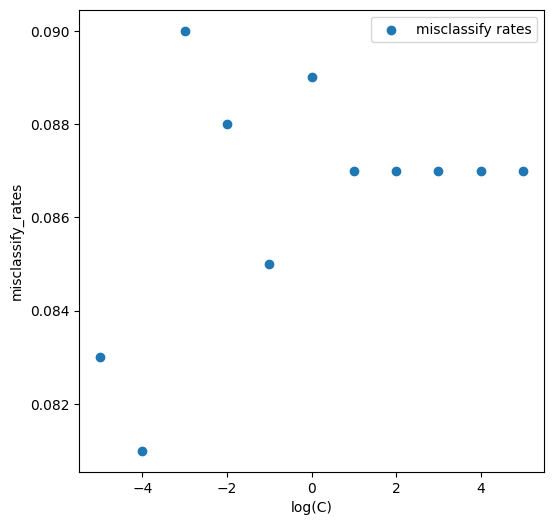

In [26]:
plt.figure(figsize=(6,6))
xx = np.linspace(-5, 5, 11)
plt.scatter(xx, misclassify_rates, marker='o', label='misclassify rates')
plt.legend()
plt.xlabel('log(C)')
plt.ylabel('misclassify_rates')
plt.show()


 5.(b)

- sub-level set of convex functions are convex set.
cp.sum_squares(cp.hstack([x, y, z])) <= 1
- left is L2 norm which is convex, right is affine.
cp.norm(cp.hstack([x, 1])) - (3*x + y) <= 0
- left is convex function
cp.inv_pos(x) + 2*cp.inv_pos(y) <= 5 with domain constraints: x > 0, y > 0 
- calculate the hessian matrix of $f(x,y) = \frac{(x+y)^2}{\sqrt(y)}, y > 0$ and check its psd property, so "convex  <= affine" gives a convex set.But i don't know how to express using dcp expressions.

- $y >= 1/(x+z) x+z > 0$
$h(u) = 1/u$ is convex at u > 0 
$\{(x, z, y) | y >= h(x+z), x+z >0\}$ is an epigraph of h(u), so is convex
z >= cp.inv_pos(x+z)
x + z >= 0
y >= 0

- the solution set of linear equations are affine sets(also polyhegron) and so is convex.
x + 2*y == 0
x - y == 0

- $\{(x,y): logx + \frac{1}{2} logy \ge 0, x > 0, y > 0\}$ is concave function's super-level set, so it is convex.
cp.log(x) + 0.5 * cp.log(y) >= 0
x >= 0
y >= 0
> In dcp, 2 variable's multiplication is not allowed

- log-sum-exp is a convex function, $-e^x$ is concave which gives "convex + convex = convex <= 0"
cp.log_sum_exp(cp.hstack([y-1, x/2])) + cp.exp(x) <= 0 